# Time Frequency Analysis of Percept recordings

## 0. Loading packages and functions, defining paths

# Importing Python and external packages


In [1]:
import os
import sys
import importlib
import json
from dataclasses import dataclass, field, fields
from itertools import compress
import csv
import pandas as pd
import numpy as np

import scipy
import matplotlib.pyplot as plt
from scipy import signal

import openpyxl
from openpyxl import Workbook, load_workbook
import xlrd

#mne
import mne_bids
import mne
from mne.time_frequency import tfr_morlet 



from importlib import reload          

# from scipy.signal import spectrogram, hanning     # hanning not found


In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('mne_bids', mne_bids.__version__)
print('mne', mne.__version__)
print('sci-py', scipy.__version__)

Python sys 3.10.8 | packaged by conda-forge | (main, Nov 24 2022, 14:07:00) [MSC v.1916 64 bit (AMD64)]
pandas 1.5.1
numpy 1.23.4
mne_bids 0.11.1
mne 1.2.3
sci-py 1.9.3


In [3]:
os.getcwd()

'c:\\Users\\habetsj\\Research\\projects\\PyPerceive\\code\\notebooks'

In [4]:
# create a path to the PyPerceive_Project folder -> project_path
# and a path to the "Data" folder and "Code" folder within the project
project_path = os.getcwd()
while project_path[-10:] != 'PyPerceive':
    project_path = os.path.dirname(project_path)

code_path = os.path.join(project_path, 'code')
sys.path.append(code_path)

# change directory to code path
os.chdir(code_path)
os.getcwd()

'c:\\Users\\habetsj\\Research\\projects\\PyPerceive\\code'

# test load JSON

In [5]:
from PerceiveImport.methods import find_folders

In [60]:
sub = '024'
json_path = os.path.join(find_folders.get_onedrive_path('perceivedata'), f'sub-{sub}', 'raw_jsons')
perceive_path = os.path.join(find_folders.get_onedrive_path('perceivedata'), f'sub-{sub}', 'raw_perceive')

fname = os.listdir(json_path)[0]
BSfile = 'sub024_ses-2021061806255999_run-BrainSense20210618063700'

In [17]:
with open(os.path.join(json_path, fname), 'r') as f:
    json_object = json.loads(f.read())

In [40]:
print(json_object.keys())

dict_keys(['AbnormalEnd', 'FullyReadForSession', 'FeatureInformationCode', 'SessionDate', 'SessionEndDate', 'ProgrammerTimezone', 'ProgrammerUtcOffset', 'ProgrammerLocale', 'ProgrammerVersion', 'PatientInformation', 'DeviceInformation', 'BatteryInformation', 'GroupUsagePercentage', 'LeadConfiguration', 'Stimulation', 'Groups', 'BatteryReminder', 'MostRecentInSessionSignalCheck', 'Impedance', 'GroupHistory', 'SenseChannelTests', 'CalibrationTests', 'DiagnosticData'])


## 1. Load Data using MainClass2

In [62]:
from PerceiveImport.classes import main_class as mainclass
importlib.reload(mainclass)

<module 'PerceiveImport.classes.main_class' from 'c:\\Users\\habetsj\\Research\\projects\\PyPerceive\\code\\PerceiveImport\\classes\\main_class.py'>

In [8]:
from PerceiveImport.classes import main_class, modality_class, metadata_class, session_class, condition_class, task_class
import PerceiveImport.methods.load_matfile as load_matfile


importlib.reload(mainclass)
importlib.reload(session_class)
importlib.reload(task_class)
importlib.reload(condition_class)
importlib.reload(metadata_class)
importlib.reload(modality_class)
importlib.reload(load_matfile)

In [7]:
# define an example instance and fill in the values of the dataclass PerceiveData 
# choose the values you are interested in analyzing further

sub021 = mainclass.PerceiveData(
    sub = "021", 
    incl_modalities=["survey"],
    incl_session = ["postop", "fu3m", "fu12m"],
    incl_condition =['m0s0'],
    incl_task = ["rest"]
)

# Funktion:
# Eingabe nur einzelner Strings, nicht mehrfacher Str in Liste 
# bei keiner Eingabe der letzten attributes, wird default aus allen Möglichkeiten herausgegeben, jedoch funktioniert nur der 1.Input jeweils
# funktioniert nur bei vollständiger metadata Tabelle und nur, wenn filenames in perceiveFilenames == filenames in directory (nicht immer der Fall, vor allem der Anfang sub-017. sub017)
# d.h. metadata vorher überprüfen: neue xlsx mit matfiles in directory + paths (paths enthalten Info zB 3MFU) -> händisch copy paste in metadata Tabelle und vervollständigen
# gezielte Definition bereits in PerceveData Class -> 

# Pitfalls:
# bei mehreren Eingaben, funktioniert immer nur der 1.Input -> zB incl_session = ["FU3M", "PostOp", "FU12M"] -> nur FU3M funktioniert, Rest ist leer
# wenn nichts eingegeben wurde, funktioniert immer nur der 1.Input der Default Liste! -> zB default Liste ["PostOp", "FU3M", ] -> nur PostOp funktioniert, Rest ist leer
# missing function: if one attribute is left out, the connection to the next Class is missing ...  
# missing function: can´t select multiple inputs simultaneously, optimal would be: input List -> outcome: concatenated dataframes of multiple DF
# load mne raw: wenn man eine Liste mit paths lädt, kann man einen einzelnen path nicht einer metadata Tabelle zuordnen, weil mit os.walk wird eine andere Reihenfolge gelistet als in der metadata Tabelle

# neue Ziele: 
# matpath_list bestenfalls in zugehöriger Reihe in DataFrame als neues column hinzufügen -> sodass nur 1 DF weitergegeben wird
# self.data ist nur von taskClass abrufbar, optimal wäre es auch von Main, modality, session und condition class self.data abrufen zu können, und raw

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub021_ses-2021080607015296_run-LMTD20210806071100_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub021_ses-2021080607015296_run-LMTD20210806071300_2.mat
Creating RawArray with float64 data, n_channels=3, n_times=5125
    Range : 0 ... 5124 =      0.000 ...    20.496 secs
Ready.
LOADED sub021_ses-2021080607015296_run-LMTD20210806071400_3.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub021_ses-2021080607015296_run-LMTD20210806071500_4.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub021_ses-2021080607015296_run-LMTD20210806071700_5.mat
Creating RawArray with float64 data, n_channels=3,

In [11]:
sub021.survey.fu3m.m0s0.rest.data['RestBSSuRingR'].get_data()

array([[ 2.96023003,  2.96023003,  8.19756008, ..., -3.87107004,
        -1.48011501,  3.41565003],
       [-8.04263409, -5.17026477,  0.45957909, ..., -5.74473864,
        -2.41279023, -1.95321114],
       [ 4.36600136,  3.10215886,  6.3192125 , ...,  2.527685  ,
         4.59579091,  7.12347591],
       [-4.21263504, -4.32649004, -1.59397002, ..., -2.04939002,
         0.91084001,  3.52950503],
       [ 9.00290141,  8.31037054,  7.73326147, ...,  3.5780762 ,
         2.77012351,  2.77012351],
       [-1.02935271, -1.60121533,  0.91498019, ..., -4.57490095,
        -2.8593131 , -3.77429329]])

In [51]:
# Beispiel: ich möchte von sub 017, alle Survey files vom M0S0 für jeden Timepoint (session) 
# erstelle je 1 DF für jede session
data = {}

sub = '021'
modality = 'Survey'
cond = 'M0S0'

session = ['FU3M']

data[sub] = {}
for s in session:
    mod = getattr(sub021, modality)
    data[sub][s] = getattr(mod, s)




In [59]:
data['021']['FU3M'].metaClass.metadata # hier soll metadata Tabelle angezeigt werden -> davon kann ich dann im nächsten Schritt mit mne data laden

,report,perceiveFilename,task,session,condition,stimState,run,badChannels,maxAmp,stimPeriodRestZeroPre,...,stimPeriodRestTwo,stimPeriodRestThree,stimPeriodRestMax,stimPeriodRestZeroPost,stimPeriodMovZero,stimPeriodMovOne,stimPeriodMovTwo,stimPeriodMovThree,stimPeriodMovMax,Unnamed: 20
0,sub-021_Report_Json_Session_Report_20210806T17...,sub021_ses-2021080607015296_run-LMTD2021080607...,RestBSSuRingL,FU3M,M0S0,Off,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-021_Report_Json_Session_Report_20210806T17...,sub021_ses-2021080607015296_run-LMTD2021080607...,RestBSSuSegmIntraL,FU3M,M0S0,Off,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-021_Report_Json_Session_Report_20210806T17...,sub021_ses-2021080607015296_run-LMTD2021080607...,RestBSSuSegmInterL,FU3M,M0S0,Off,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-021_Report_Json_Session_Report_20210806T17...,sub021_ses-2021080607015296_run-LMTD2021080607...,RestBSSuRingR,FU3M,M0S0,Off,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-021_Report_Json_Session_Report_20210806T17...,sub021_ses-2021080607015296_run-LMTD2021080607...,RestBSSuSegmIntraR,FU3M,M0S0,Off,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,sub-021_Report_Json_Session_Report_20210806T17...,sub021_ses-2021080607015296_run-LMTD2021080607...,RestBSSuSegmInterR,FU3M,M0S0,Off,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
# load the chosen perceive .mat files with MNE
# e.g.: from subject 021 all Survey files from FU3M 
# store each loaded raw file in a dictionary with keys named raw_idx -> idx unfortunately doesn´t match with DF because paths are in different order (initially looped through folders...)

sub = "021"
raw_perceive_path = find_folders.get_onedrive_path("raw_perceive", sub)

raw_021 = {}
count = -1
path_list = []


for file in data['021']['FU3M'].metaClass.metadata["perceiveFilename"]:

    # make a list with all paths to the selected perceive files
    path_list.append(os.path.join(raw_perceive_path, file))
    

# load each path with mne and store in a dictionary raw_021{}
for path in path_list:

    count +=1

    raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
        path,
        info={},
        data_name='data'
        )

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


c:\Users\jebe12\anaconda3\envs\pyPerceive_dev\lib\site-packages\pymatreader\utils.py:230: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_03. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_13. Making it a MISC channel.
  raw_021["raw_{0}".for

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1A1B. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1B1C. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1A1C. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\U

Creating RawArray with float64 data, n_channels=3, n_times=5125
    Range : 0 ... 5124 =      0.000 ...    20.496 secs
Ready.


C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1A2A. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1B2B. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1C2C. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(


Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_03. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_13. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_02. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\j

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A1B. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1B1C. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A1C. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\U

Creating RawArray with float64 data, n_channels=3, n_times=5125
    Range : 0 ... 5124 =      0.000 ...    20.496 secs
Ready.


C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A2A. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1B2B. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
C:\Users\jebe12\AppData\Local\Temp\ipykernel_17080\1404276528.py:24: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1C2C. Making it a MISC channel.
  raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(


In [65]:
raw_021["raw_1"].info.keys()


dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

In [40]:
raw_017FU3M.keys()

dict_keys(['raw_0', 'raw_1', 'raw_2', 'raw_3', 'raw_4', 'raw_5'])

In [50]:
raw_017FU3M["raw_1"].info.keys()

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

### Define variables 

In [19]:



ch_names = raw.ch_names
n_chan = len(ch_names)
n_time_samps = raw.n_times #nsamples
time_secs = raw.times #timepoints set to zero
ch_trials = raw._data
sampling_freq = raw.info['sfreq']
time_duration = (n_time_samps/sampling_freq).astype(float)



print(
      f'The data object has:\n\t{n_time_samps} time samples,'
      f'\n\tand a sample frequency of {sampling_freq} Hz' 
      f'\n\twith a recording duration of {time_duration} seconds.' 
      f'\n\t{n_chan} channels were labeled as \n{ch_names}.'
)

The data object has:
	5312 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 21.248 seconds.
	3 channels were labeled as 
['LFP_Stn_R_1A2A', 'LFP_Stn_R_1B2B', 'LFP_Stn_R_1C2C'].


## 2. MNE basics

In [ ]:

sub017 = mainclass.PerceiveData(
    sub = "017", 
    incl_modalities=["Survey"],
    incl_session = ["FU12M"],
    incl_condition =["M0S0"],
    incl_task = ["RestBSSuRingR"]
    )

In [11]:
# to get information on mne function type 
# mne.<function_name>?

mne.preprocessing?

Type:        module
String form: <module 'mne.preprocessing' from 'c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev\\lib\\site-packages\\mne\\preprocessing\\__init__.py'>
File:        c:\users\jebe12\anaconda3\envs\pyperceive_dev\lib\site-packages\mne\preprocessing\__init__.py
Docstring:   Preprocessing with artifact detection, SSP, and ICA.


In [ ]:
# mne uses multiple submodules

# e.g. mne.preprocessing, 
# mne.viz for visualisation
# mne.io for reading and writing data
# mne.stats for statistics


# you can import submodules directly 
# e.g. from mne.preprocessing import eog

In [21]:
rawsub017_metadata = sub017.Survey.FU12M.M0S0.RestBSSuRingR.metadata_selection

In [24]:
# rawsub017_data is a dictionary!! keys=raw_0 -> value=idx 0 of metadata, mne loaded perceive.mat file
# mne.io.read_raw_fieldtrip() used
rawsub017_data = sub017.Survey.FU12M.M0S0.RestBSSuRingR.data
rawsub017_data.keys()

dict_keys(['raw_0'])

In [28]:
raw = rawsub017_data["raw_0"]
raw.info.keys()

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

In [46]:
raw.info["bads"]

[]

In [127]:
raw.ch_names
n_chan = len(raw.ch_names)
raw.n_times #umber of samples
raw.times #timepoints set to zero
raw._data # channel trials 
raw.info['sfreq'] # sampling frequency
time_duration = (n_time_samps/sampling_freq).astype(float)



print(
      f'The data object has:\n\t{raw.n_times} time samples,'
      f'\n\tand a sample frequency of {raw.info["sfreq"]} Hz' 
      f'\n\twith a recording duration of {time_duration} seconds.' 
      f'\n\t{n_chan} channels were labeled as \n{raw.ch_names}.'
)

The data object has:
	5288 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 21.152 seconds.
	6 channels were labeled as 
['LFP_R_1A1B_STN', 'LFP_R_1B1C_STN', 'LFP_R_1A1C_STN', 'LFP_R_2A2B_STN', 'LFP_R_2B2C_STN', 'LFP_R_2A2C_STN'].


In [29]:
# convert data to pd.DataFrame
raw.to_data_frame()

,time,LFP_R_1A1B_STN,LFP_R_1B1C_STN,LFP_R_1A1C_STN,LFP_R_2A2B_STN,LFP_R_2B2C_STN,LFP_R_2A2C_STN
0,0.000,5.054857,-4.895765,0.113855,-2.493527,-0.336990,-2.960230
1,0.004,1.909613,-3.984925,-0.455420,-5.100396,-4.156216,-6.262025
2,0.008,2.808254,-5.920460,-3.529505,-6.233818,-5.167187,-6.717445
3,0.012,4.942527,-2.846375,1.366260,-3.173580,-0.336990,-3.187940
4,0.016,8.200101,-3.301795,4.098780,-2.493527,-0.561651,-1.593970
...,...,...,...,...,...,...,...
5283,21.132,-1.347962,0.000000,0.455420,4.080317,-14.265930,-9.222255
5284,21.136,-3.594565,3.984925,2.618665,7.027213,-16.849524,-9.108400
5285,21.140,-2.695924,3.301795,1.366260,7.820608,-18.197485,-12.865615
5286,21.144,-0.112330,1.366260,-1.024695,6.687186,-19.770108,-13.890310


In [30]:
# convert data to NumPy array
raw.get_data()


array([[  5.05485708,   1.90961267,   2.80825393, ...,  -2.69592377,
         -0.11233016,   0.56165079],
       [ -4.89576505,  -3.98492504,  -5.92046005, ...,   3.30179503,
          1.36626001,   0.68313001],
       [  0.113855  ,  -0.45542   ,  -3.52950503, ...,   1.36626001,
         -1.02469501,   2.39095502],
       [ -2.4935271 ,  -5.10039633,  -6.23381774, ...,   7.82060771,
          6.6871863 ,   8.61400269],
       [ -0.33699047,  -4.15621582,  -5.16718724, ..., -18.19748548,
        -19.77010768, -18.75913627],
       [ -2.96023003,  -6.26202506,  -6.71744506, ..., -12.86561512,
        -13.89031013, -11.72706511]])

In [34]:
raw.interpolate_bads

<bound method interpolate_bads of <RawArray | 6 x 5288 (21.1 s), ~259 kB, data loaded>>

## 3. Exploring and plotting data

### MNE built-in plotting

In [39]:
# mne built-in methods

raw.plot_psd()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


ValueError: picks (NoneNone, treated as "data") yielded no channels, consider passing picks explicitly

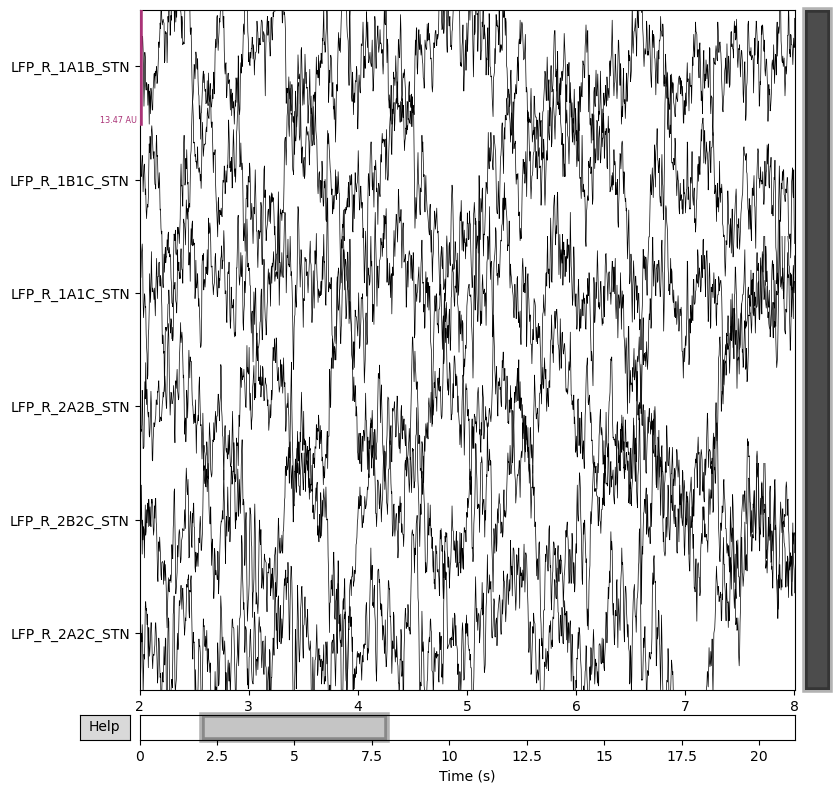

Figure(800x800)


In [93]:
fig = raw.plot(start=2, duration=6)
print(fig)


Effective window size : 1.024 (s)


C:\Users\jebe12\AppData\Local\Temp\ipykernel_15384\3096929646.py:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot(picks = chs_to_plot, average=False, color='b')
c:\Users\jebe12\anaconda3\envs\pyPerceive_dev\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


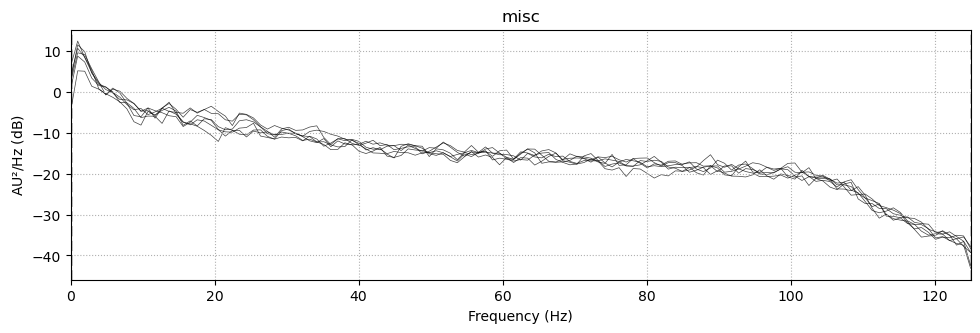

In [50]:
chs_to_plot = [
    'LFP_R_1A1B_STN', 
    'LFP_R_1B1C_STN', 
    'LFP_R_1A1C_STN',
    'LFP_R_2A2B_STN', 
    'LFP_R_2B2C_STN', 
    'LFP_R_2A2C_STN',
    ]

# to plot spectral power create object spectrum
spectrum = raw.compute_psd(picks = chs_to_plot )

# spectrum has a built-in plot() method 
spectrum.plot(picks = chs_to_plot, average=False, color='b')

### Matplotlib Playground

In [128]:
# extract a selection of raw[]

start_stop_seconds = np.array([11, 13])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)

channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]

print(f'We here selected the timepoints from {start_sample} until {stop_sample}' 
      f'\nand selected the channel {raw.ch_names[channel_index]}')

# print(raw_selection)

We here selected the timepoints from 2750 until 3250
and selected the channel LFP_R_1A1B_STN


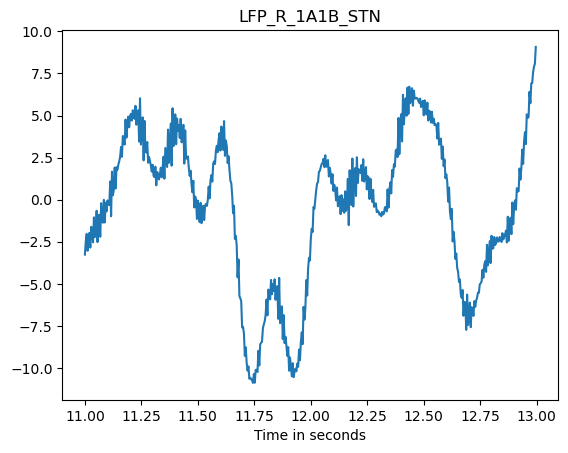

In [125]:
# plot the selected 2 arrays

x = raw_selection[1]        # time in seconds
y = raw_selection[0].T      # data from ch_trials[channel_index]

plt.plot(x, y)

plt.title(str(raw.ch_names[channel_index]))
plt.xlabel("Time in seconds")
# plt.ylabel() ???

plt.show()

<Figure size 640x480 with 0 Axes>

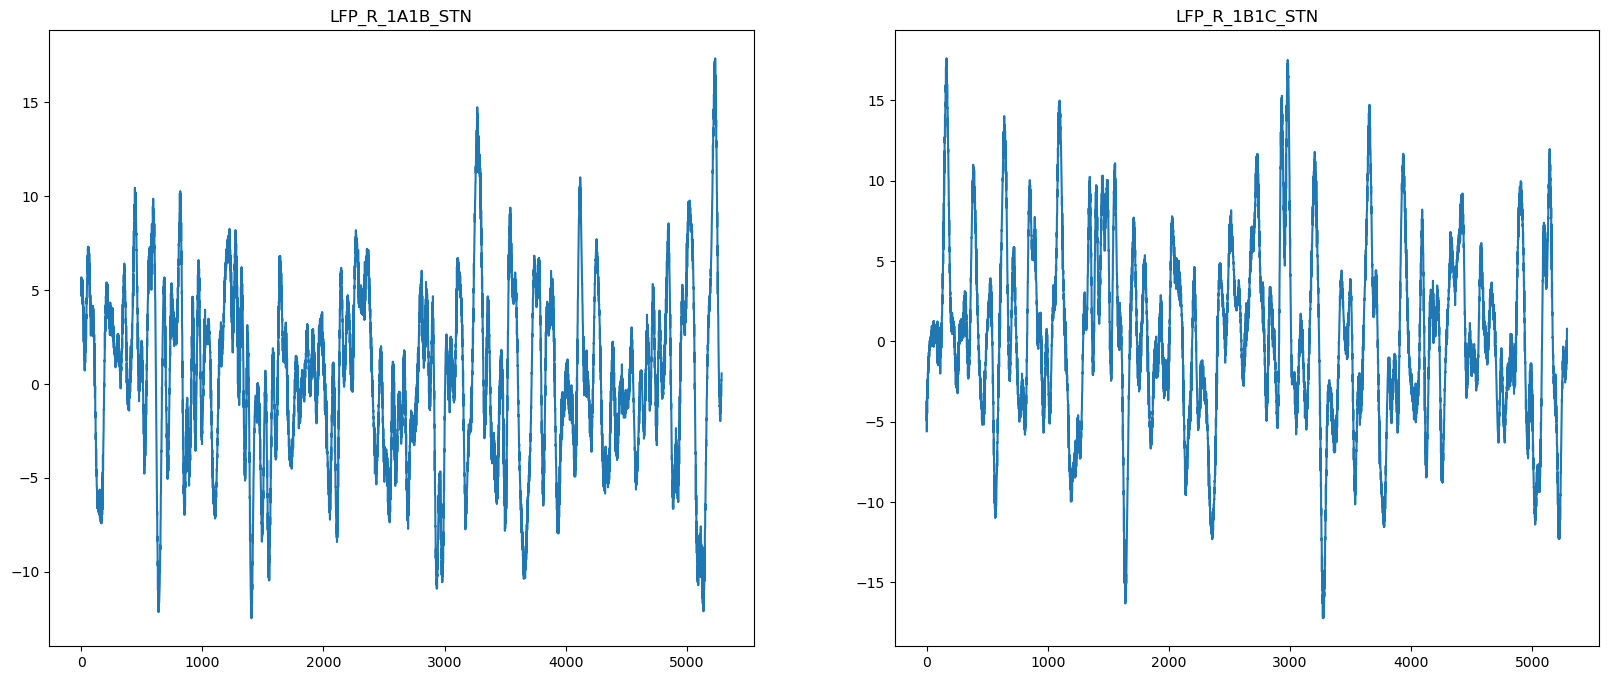

In [129]:
# plotting first and second trials from first 2 channels 

plt.suptitle("Raw data of channels left and right")

plt.figure(figsize= (20, 8))

# plot raw data of channel LFP_R_1A1B_STN
plt.subplot(1,2,1)
plt.plot(raw._data[0])
plt.title(str(raw.ch_names[0]))

# plot raw data of channel LFP_R_1B1C_STN
plt.subplot(1,2,2)
plt.plot(raw._data[1])
plt.title(str(raw.ch_names[1]))

plt.show()


In [64]:
# from Varvara

#Make some nice plots of the data

#channels to plot:
chs_to_plot = [
    'LFP_R_1A1B_STN', 
    'LFP_R_1B1C_STN', 
    'LFP_R_1A1C_STN',
    'LFP_R_2A2B_STN', 
    'LFP_R_2B2C_STN', 
    'LFP_R_2A2C_STN',
    ]

plot_times = raw.times #timepoints set to zero
xticks = np.linspace(0, plot_times[-1], 5) #make 5 x-axis ticks, dividing the seconds by 5

fig, axes = plt.subplots(
    1, len(chs_to_plot), figsize=(18, 6)
) #define n of subplots and size

# axes = axes.flatten()
ax_c = 0 

for i, name in enumerate(chs_to_plot):

    
    if name in chs_to_plot:

        if name[-3:] == 'STN': # last three letters 
            axes[ax_c].psd(raw._data[i, :]) # e.g. raw._data[1,:] will output index 1 of all raw._data -> data from 2nd channel 
            axes[ax_c].set_title(
                f'PSD {name}',
                fontsize=16, color='r'
            )

        else:
            
            axes[ax_c].plot(plot_times, raw._data[i, :]) # e.g. raw._data[1,:] will output index 1 of all raw._data -> data from 2nd channel 
            axes[ax_c].set_title(name, fontsize=16, color='r')
            axes[ax_c].set_xticks(xticks)
            axes[ax_c].set_xticklabels(np.around(xticks / 60, 1))
                
        ax_c += 1 # count for-loop

In [63]:
raw._data

array([[  5.05485708,   1.90961267,   2.80825393, ...,  -2.69592377,
         -0.11233016,   0.56165079],
       [ -4.89576505,  -3.98492504,  -5.92046005, ...,   3.30179503,
          1.36626001,   0.68313001],
       [  0.113855  ,  -0.45542   ,  -3.52950503, ...,   1.36626001,
         -1.02469501,   2.39095502],
       [ -2.4935271 ,  -5.10039633,  -6.23381774, ...,   7.82060771,
          6.6871863 ,   8.61400269],
       [ -0.33699047,  -4.15621582,  -5.16718724, ..., -18.19748548,
        -19.77010768, -18.75913627],
       [ -2.96023003,  -6.26202506,  -6.71744506, ..., -12.86561512,
        -13.89031013, -11.72706511]])

In [75]:
raw.tmin

0.0

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


C:\Users\jebe12\AppData\Local\Temp\ipykernel_15384\3226861770.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin = 5, fmax = 50, picks = 1, tmin = raw.tmin, tmax = raw.tmax,  dB = False, estimate = 'amplitude')
c:\Users\jebe12\anaconda3\envs\pyPerceive_dev\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


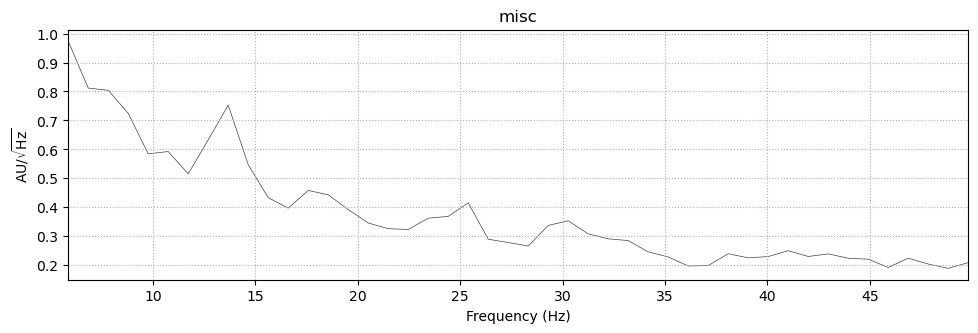

In [76]:
#raw.compute_psd(picks = chs_to_plot ).plot(fmin = 5, fmax = 50, picks = 1, tmin = 0, tmax = 10, dB = False, estimate = 'amplitude')
raw.plot_psd(fmin = 5, fmax = 50, picks = 1, tmin = raw.tmin, tmax = raw.tmax,  dB = False, estimate = 'amplitude')


# time: tmin - tmax (continuos data)

In [80]:
chan = 1 # set channel we want

start_time = int((1000 / 1000) * raw.info['sfreq']) # 250
end_time   = int((10000 / 1000) * raw.info['sfreq']) # 2500

raw._data[chan, start_time:end_time]


array([ 1.13855001, -2.16324502, -6.37588006, ...,  7.74214007,
        5.35118505,  5.57889505])

In [114]:
mydat = raw.get_data(picks=['LFP_R_1A1B_STN'], start=1, stop=201)
print(mydat.shape)

(1, 200)


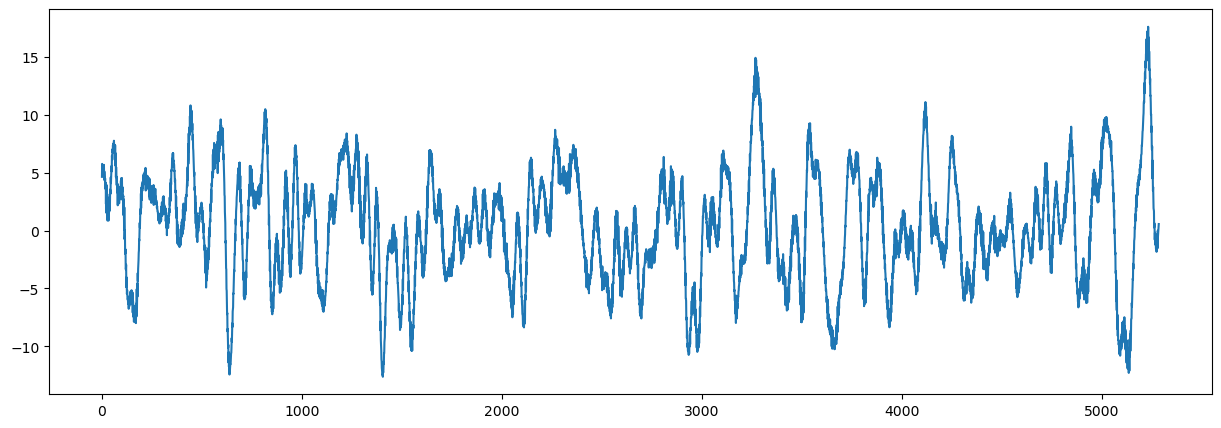

In [115]:
fig, ax = plt.subplots(figsize=[15, 5])

ax.plot(raw.get_data(picks=['LFP_R_1A1B_STN'],start=1, stop=20000).T)
plt.show()

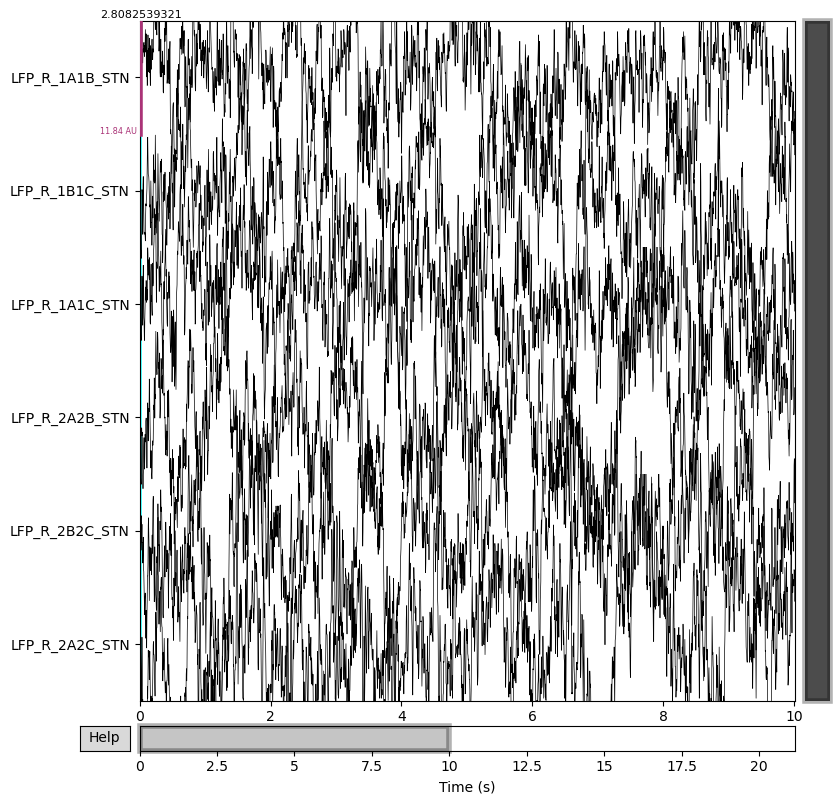

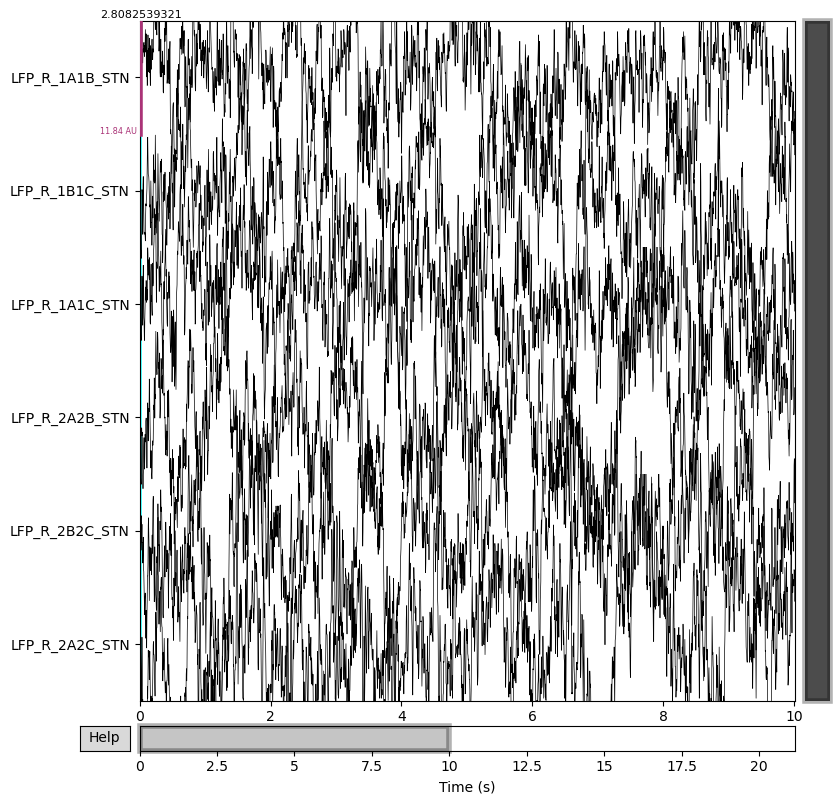

In [90]:
raw.plot(raw.get_data(picks='LFP_R_1A1B_STN'))

In [96]:
raw.info['bads'] = [
    'LFP_R_1A1B_STN', 
    'LFP_R_1B1C_STN', 
    'LFP_R_1A1C_STN',
    'LFP_R_2A2B_STN', 
    'LFP_R_2B2C_STN', 
    'LFP_R_2A2C_STN',] 

picks = mne.pick_types(raw.info, meg='mag', eeg=False, eog=False,
                       stim=False, exclude='bads')

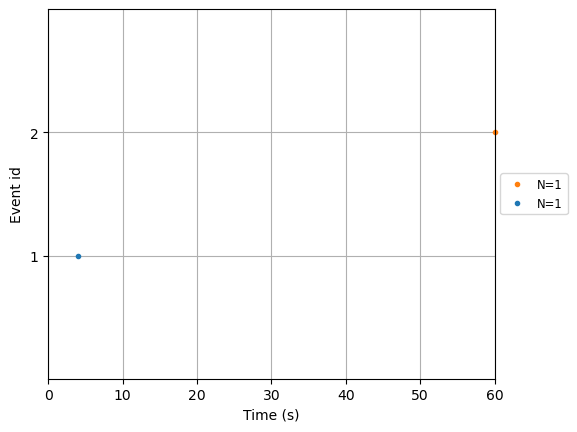

Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2 events and 2501 original time points ...
1 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


C:\Users\jebe12\AppData\Local\Temp\ipykernel_15384\1477881095.py:9: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks = 0)


IndexError: list index out of range

In [97]:
#events = mne.find_events(raw, stim_channel='LFP_R_13_STN') -> no stim channel in BrainSenseSurvey
trial_onsets = np.array([
       [ 1000 ,      0 ,    1],
       [ 15000 ,      0 ,    2 ]]) #we need the samples

event_dict = {'NoStim':1,'Threshold':2}
fig = mne.viz.plot_events(trial_onsets, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)
epochs = mne.Epochs(raw,events=trial_onsets,event_id = event_dict, tmin=0, tmax=10, baseline = None, preload = True)
epochs.plot_image(picks = 0)

In [99]:
# nostim_ep = epochs['NoStim']
# stim_ep = epochs['Threshold']
# stim_ep.plot_image(picks = 1)

In [100]:
M = 200
NFFT = M
win = hanning(M)
overlap = 0.25
overlap_samples = int(round(M*overlap)) # overlap in samples
t, f, S = spectrogram(mydat,window=win,nperseg=M,noverlap=overlap_samples,nfft=NFFT)

# Compute average spectrum
avg_S = np.mean(S,axis=1)

NameError: name 'hanning' is not defined

In [108]:
vars(tfr_morlet)

{'__wrapped__': <function mne.time_frequency.tfr.tfr_morlet(inst, freqs, n_cycles, use_fft=False, return_itc=True, decim=1, n_jobs=None, picks=None, zero_mean=True, average=True, output='power', verbose=None)>,
 '__qualname__': 'tfr_morlet',
 '__globals__': {'__name__': 'mne.time_frequency.tfr',
  '__doc__': 'A module which implements the time-frequency estimation.\n\nMorlet code inspired by Matlab code from Sheraz Khan & Brainstorm & SPM\n',
  '__package__': 'mne.time_frequency',
  '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x1e124cdfb80>,
  '__spec__': ModuleSpec(name='mne.time_frequency.tfr', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001E124CDFB80>, origin='c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev\\lib\\site-packages\\mne\\time_frequency\\tfr.py'),
  '__file__': 'c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev\\lib\\site-packages\\mne\\time_frequency\\tfr.py',
  '__cached__': 'c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev

In [107]:
freqs = np.arange(1, 125)
D = tfr_morlet(epochs, freqs=freqs, n_cycles=6, return_itc=False, average=True, picks = 1)

In [110]:
spectrogram(
    mydat,
    fs=125.0, 
#             window=('hanning', 0.25), 
    nperseg=1, 
    noverlap=0.25, 
    nfft=None, 
    detrend='constant', 
    return_onesided=True, 
    scaling='density', 
    axis=- 1, 
    mode='psd')

(array([0.]),
 array([0.004, 0.012, 0.02 , 0.028, 0.036, 0.044, 0.052, 0.06 , 0.068,
        0.076, 0.084, 0.092, 0.1  , 0.108, 0.116, 0.124, 0.132, 0.14 ,
        0.148, 0.156, 0.164, 0.172, 0.18 , 0.188, 0.196, 0.204, 0.212,
        0.22 , 0.228, 0.236, 0.244, 0.252, 0.26 , 0.268, 0.276, 0.284,
        0.292, 0.3  , 0.308, 0.316, 0.324, 0.332, 0.34 , 0.348, 0.356,
        0.364, 0.372, 0.38 , 0.388, 0.396, 0.404, 0.412, 0.42 , 0.428,
        0.436, 0.444, 0.452, 0.46 , 0.468, 0.476, 0.484, 0.492, 0.5  ,
        0.508, 0.516, 0.524, 0.532, 0.54 , 0.548, 0.556, 0.564, 0.572,
        0.58 , 0.588, 0.596, 0.604, 0.612, 0.62 , 0.628, 0.636, 0.644,
        0.652, 0.66 , 0.668, 0.676, 0.684, 0.692, 0.7  , 0.708, 0.716,
        0.724, 0.732, 0.74 , 0.748, 0.756, 0.764, 0.772, 0.78 , 0.788,
        0.796, 0.804, 0.812, 0.82 , 0.828, 0.836, 0.844, 0.852, 0.86 ,
        0.868, 0.876, 0.884, 0.892, 0.9  , 0.908, 0.916, 0.924, 0.932,
        0.94 , 0.948, 0.956, 0.964, 0.972, 0.98 , 0.988, 0.996,

In [117]:
raw = raw.filter(l_freq=90, h_freq=5, picks=['LFP_R_1A1B_STN', 'LFP_R_1B1C_STN'])

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 413 samples (1.652 sec)



## 4. Preprocessing

In [119]:
# detecting power line noise
fig = raw.compute_psd(picks=chs_to_plot, tmax=np.inf, fmax=125.0, average=None).plot(picks=chs_to_plot)
fig.show()

# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

Effective window size : 1.024 (s)
Aggregating Welch estimates (median) before plotting...


C:\Users\jebe12\AppData\Local\Temp\ipykernel_15384\3965450946.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw.compute_psd(picks=chs_to_plot, tmax=np.inf, fmax=125.0, average=None).plot(picks=chs_to_plot)
c:\Users\jebe12\anaconda3\envs\pyPerceive_dev\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_15384\3965450946.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [122]:
#from mne.preprocessing import create_eog_epochs, create_ecg_epochs, compute_proj_ecg, compute_proj_eog

# detect ecg artifacts

ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
ecg_epochs.plot_image(combine='mean')

ValueError: Unable to generate artificial ECG channel